In [0]:
!pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 95kB/s 
     |████████████████████████████████| 491kB 49.7MB/s 
     |████████████████████████████████| 3.2MB 43.5MB/s 
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0


In [0]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [0]:
from tensorflow import keras

In [0]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Using TensorFlow backend.


In [0]:
path = (r"/content/Project")

In [0]:
path

'/content/Project'

In [0]:
dir_list = os.listdir(path) 

In [0]:
dir_list

['train', 'test', 'sample_submission.csv']

In [0]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [0]:
filenames = os.listdir(r"/content/Project/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [0]:
df.head()

,filename,category
0,dog.1718.jpg,1
1,cat.6964.jpg,0
2,cat.11361.jpg,0
3,dog.12143.jpg,1
4,dog.6501.jpg,1


In [0]:
df.tail()

,filename,category
24995,dog.8410.jpg,1
24996,cat.164.jpg,0
24997,dog.5879.jpg,1
24998,dog.5445.jpg,1
24999,dog.4594.jpg,1


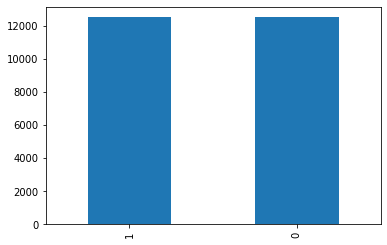

In [0]:
df['category'].value_counts().plot.bar()

In [0]:
sample = random.choice(filenames)

In [0]:
sample

'dog.7667.jpg'

In [0]:
image = load_img("/content/Project/train/"+sample)

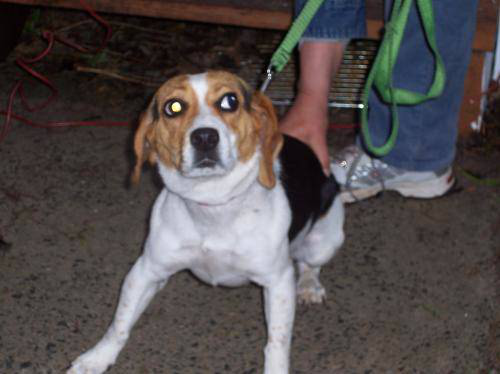

In [0]:
image

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [0]:
model = Sequential()

In [0]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


In [0]:
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [0]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [0]:
earlystop = EarlyStopping(patience=10)

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
callbacks = [earlystop, learning_rate_reduction]

In [0]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

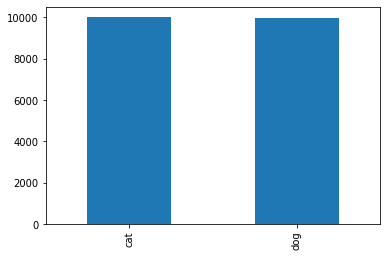

In [0]:
train_df['category'].value_counts().plot.bar()

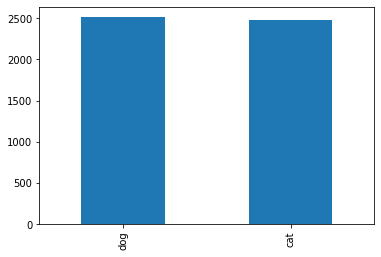

In [0]:
validate_df['category'].value_counts().plot.bar()

In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [0]:
path_new = (r"/content/Project/train")

In [0]:
path_new

'/content/Project/train'

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    path_new, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    path_new, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [0]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    path_new, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


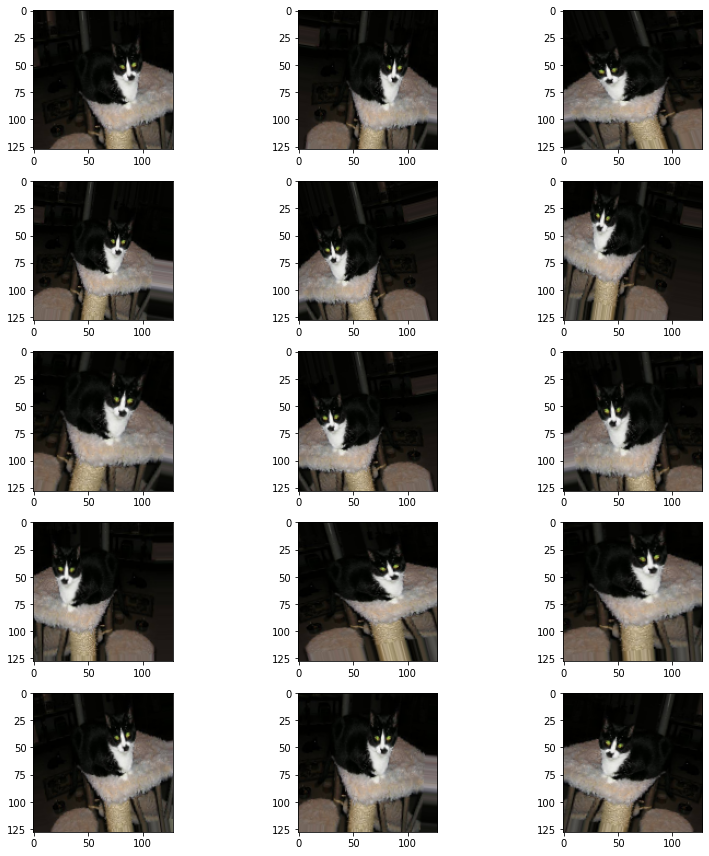

In [0]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [43]:
epochs=3 if FAST_RUN else 10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1333/1333 [==============================] - 1166s 875ms/step - loss: 0.5974 - acc: 0.6906 - val_loss: 0.6167 - val_acc: 0.6621
Epoch 2/10
1333/1333 [==============================] - 1158s 869ms/step - loss: 0.5368 - acc: 0.7372 - val_loss: 0.4808 - val_acc: 0.7673
Epoch 3/10
1333/1333 [==============================] - 1210s 908ms/step - loss: 0.4955 - acc: 0.7654 - val_loss: 0.5143 - val_acc: 0.7597
Epoch 4/10
1333/1333 [==============================] - 1253s 940ms/step - loss: 0.4640 - acc: 0.7842 - val_loss: 0.4229 - val_acc: 0.8064
Epoch 5/10
1333/1333 [==============================] - 1291s 969ms/step - loss: 0.4310 - acc: 0.8033 - val_loss: 1.0739 - val_acc: 0.5795
Epoch 6/10
1333/1333 [==============================] - 1273s 955ms/step - loss: 0.4142 - acc: 0.8155 - val_loss: 0.5790 - val_acc: 0.7364

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/10
1333/1333 [==============================] - 1287s 965ms/step - loss: 0.36

In [0]:
model.save_weights("model.h5")

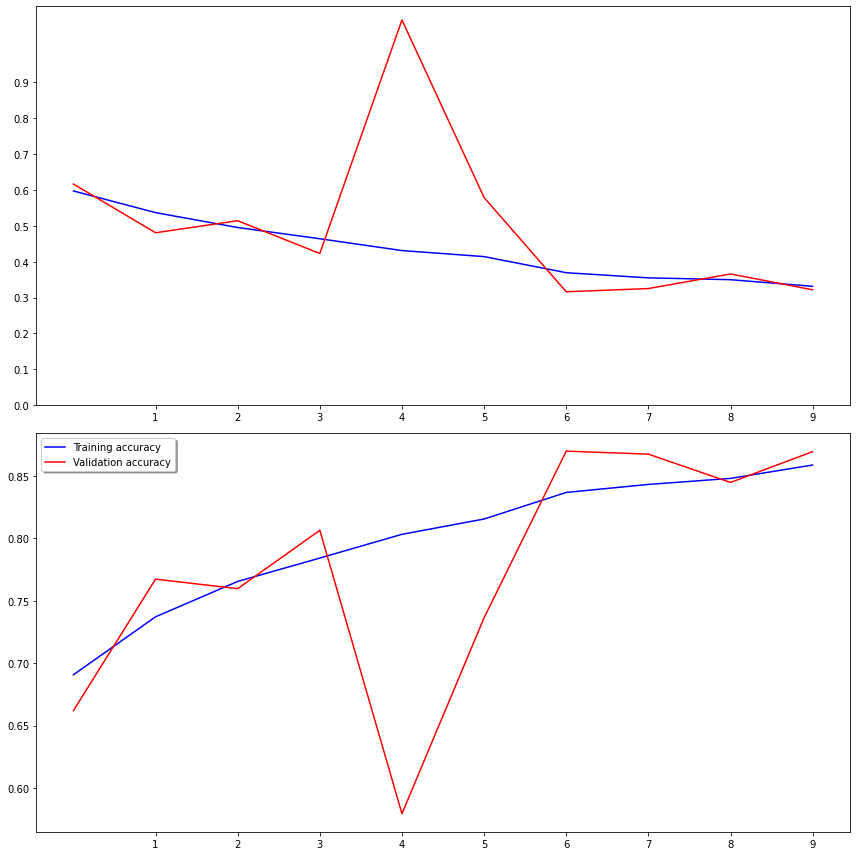

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [0]:
test_filenames = os.listdir(r"/content/Project/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [47]:
path_test=(r"/content/Project/test")
path_test

'/content/Project/test'

In [48]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    path_test, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [0]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [0]:
test_df['category'] = np.argmax(predict, axis=-1)

In [0]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [0]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [0]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

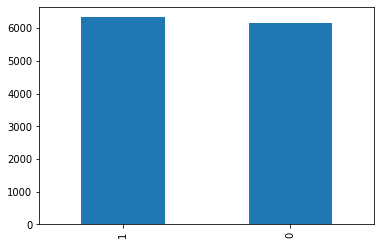

In [54]:
test_df['category'].value_counts().plot.bar()

In [55]:
sample_test = test_df.head(18)
sample_test.head()


,filename,category
0,4011.jpg,0
1,34.jpg,1
2,6353.jpg,0
3,3379.jpg,0
4,7463.jpg,1


In [56]:
plt.figure(figsize=(12, 24))

<Figure size 864x1728 with 0 Axes>

<Figure size 864x1728 with 0 Axes>

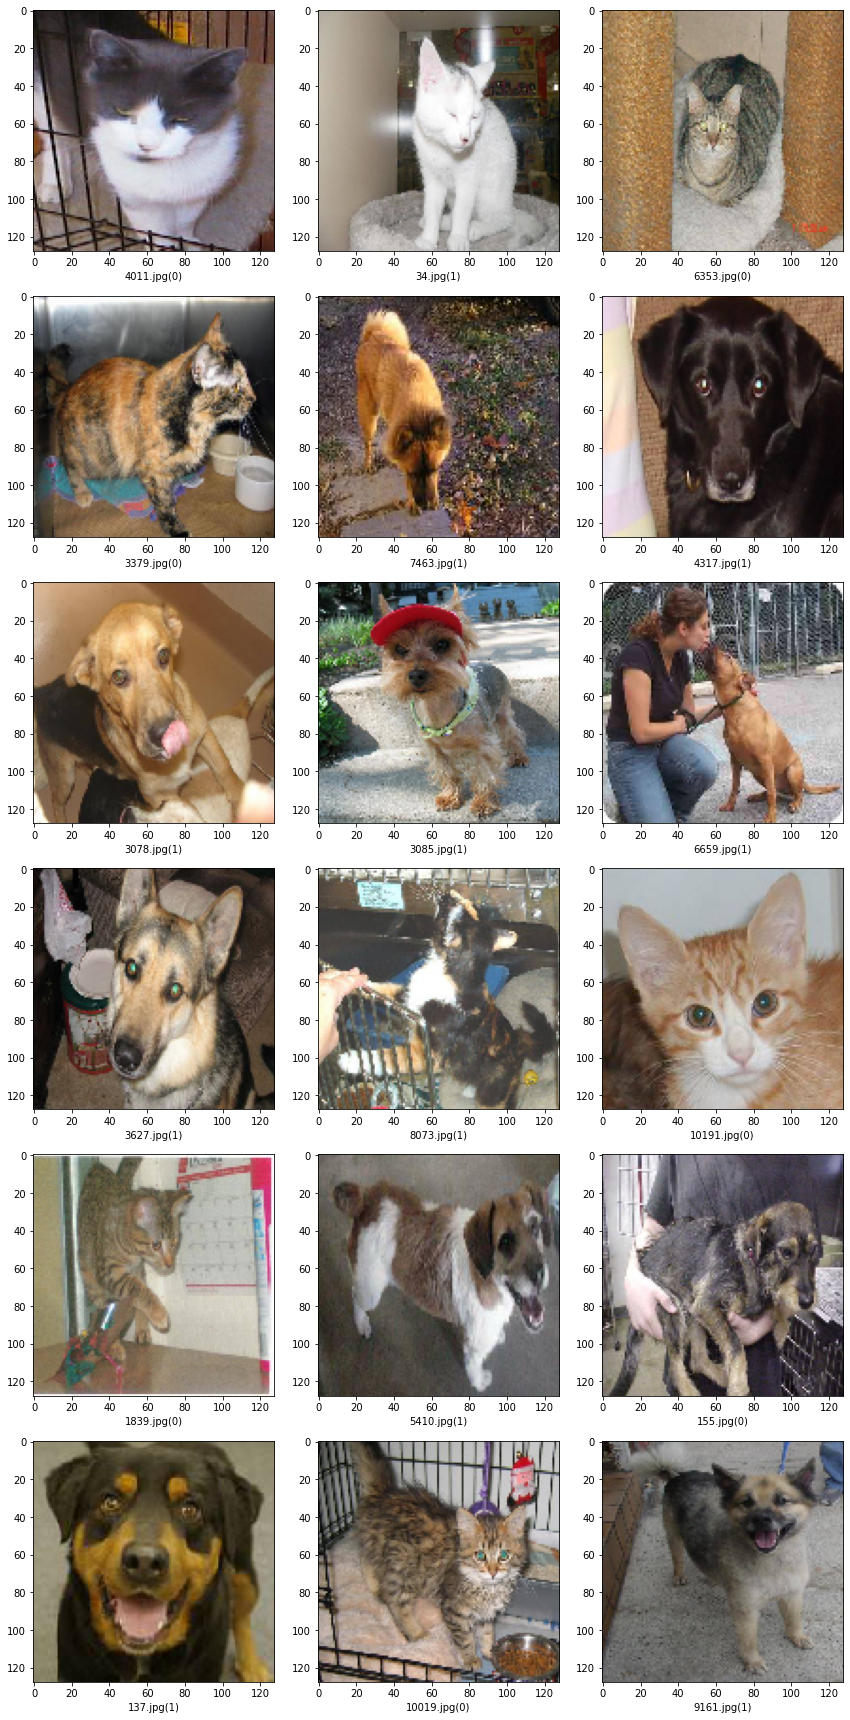

In [57]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/Project/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()